In [1]:
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import nb_utils
from ms_io import ms_io

## Import the spectra and the identifications

In [2]:
peak_dir = "/media/maesk/WD/MS/PXD000561/mgf"
pref = 'mzspec:PXD000561:'
filenames = [os.path.join(peak_dir, filename)
             for filename in os.listdir(peak_dir)
             if filename.endswith('.mgf')]
file_labels = '/media/maesk/WD/MS/PXD000561/kim2014_ids.csv'

df_identifier = []
df_charge = []
df_precursor_mz = []

for filename in tqdm(filenames):
    for sp in ms_io.get_spectra(filename):
        df_identifier.append(pref + sp.identifier)
        df_charge.append(sp.precursor_charge)
        df_precursor_mz.append(sp.precursor_mz)

df_dic = {'identifier': df_identifier,
          'precursor_charge': df_charge,
          'precursor_mz': df_precursor_mz}
df_sp = pd.DataFrame(df_dic)

labels = pd.read_csv(file_labels)

  0%|          | 0/2211 [00:00<?, ?it/s]

In [3]:
print(len(df_sp))
print(len(labels))
sp_id = pd.merge(df_sp, labels[['identifier', 'sequence']],
                                  'left', 'identifier')

24992480
24992480


In [4]:
sp_id.to_csv('analyzePXD000561dataset/test.csv')

## Plot the total number of spectra for each charge

[  973277 14749401  6792844  1822149   485490   131604    25462     7694
     2729     1093      413      214       31        4       75]
[  96830 7003577 2798645  502191   75947    9139     816      88       2
       0       0       0       0       0       0]


,identifier,precursor_mz,sequence
precursor_charge,,,
1,973277,973277,96830
2,14749401,14749401,7003577
3,6792844,6792844,2798645
4,1822149,1822149,502191
5,485490,485490,75947
6,131604,131604,9139
7,25462,25462,816
8,7694,7694,88
9,2729,2729,2


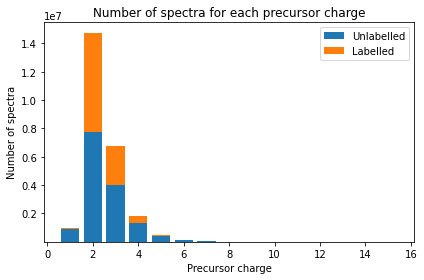

In [5]:
fig_path = 'analyzePXD000561dataset/'

sp_per_charge = sp_id.groupby(by='precursor_charge').count()
sp_per_charge_ = sp_per_charge

plt_charges = sp_per_charge_.index.to_numpy()
plt_nsp = sp_per_charge_['identifier'].to_numpy()
plt_nsp_id = sp_per_charge_['sequence'].to_numpy()
plt_nsp_notid = plt_nsp - plt_nsp_id

print(plt_nsp)
print(plt_nsp_id)

fig, ax = plt.subplots()
ax.bar(plt_charges, plt_nsp_notid, label = 'Unlabelled')
ax.bar(plt_charges, plt_nsp_id, bottom=plt_nsp_notid, label = 'Labelled')
ax.legend()
ax.set(title='Number of spectra for each precursor charge',
       xlabel='Precursor charge', ylabel='Number of spectra')
plt.tight_layout()
plt.savefig(fig_path+'sp_per_charge.png', dpi=300)
plt.plot()

sp_per_charge

## Plot the precursor mz distribution

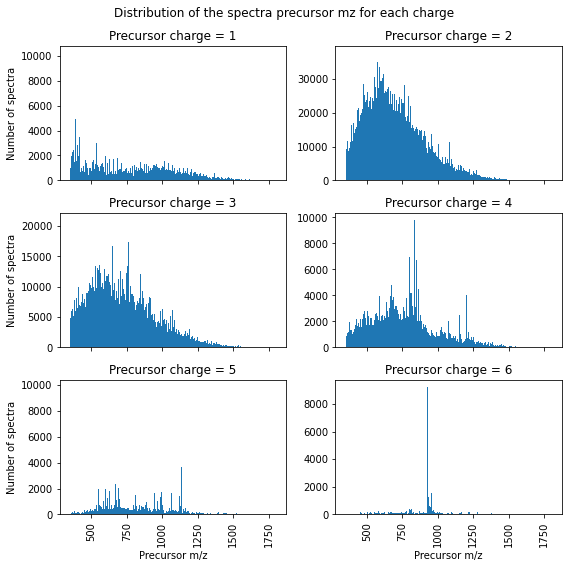

In [6]:
nrow = 3
ncol = 2
fig, axs = plt.subplots(nrow, ncol, sharex=True, figsize=(8,8))
fig.suptitle('Distribution of the spectra precursor mz for each charge')
mask_charge = sp_id['precursor_charge'] <= 6
h = sp_id[mask_charge].hist(column='precursor_mz',
                    by='precursor_charge',
                    bins=range(350, 1800),
                    ax=axs)
for i in range(nrow):
    axs[i,0].set(ylabel='Number of spectra')

for i in range(ncol):
    axs[2,i].set(xlabel='Precursor m/z')

for i in range(nrow):
    for j in range(ncol):
        axs[i,j].set(title='Precursor charge = '+axs[i,j].get_title())

plt.tight_layout()
plt.savefig(fig_path+'prec_mz_distr.png', dpi=300)

## The proportion of spectra having a label

In [7]:
print('Proportion: %.2f' % (np.sum(plt_nsp_id)/np.sum(plt_nsp)*100.0))

Proportion: 41.96


## The mass spectrometer

In [5]:
development = []
tissue = []
spectrometer = []

for id in sp_id['identifier'].tolist():
    _, _, id, _, _ = id.split(':')
    d, t, _, ms, _, _ = id.split('_')

    development.append(d)
    tissue.append(t)
    spectrometer.append(ms)

sp_id.insert(0, 'development', development)
sp_id.insert(1, 'spectrometer', spectrometer)
sp_id.insert(2, 'tissue', tissue)

In [14]:
nsp = len(sp_id)

df_summary = sp_id.groupby(['development', 'tissue']).count()

prop_sp = df_summary['identifier'].to_numpy() / nsp * 100
prop_labels = df_summary['sequence'].to_numpy() / df_summary['identifier'].to_numpy() * 100

df_summary.insert(4, 'prop_tot', prop_sp)
df_summary.insert(5, 'prop_labelled', prop_labels)

df_summary
df_summary.to_csv(fig_path+'summary.csv')

## The number of different labels

In [16]:
unique_labels = labels.groupby('sequence').count()
print(unique_labels)

                               Unnamed: 0  identifier  precursor_charge  \
sequence                                                                  
AAAAAAAAAAAAAAAGAGAGAK                 20          20                20   
AAAAAAAAAAAAAATATAGPR                   1           1                 1   
AAAAAAAAAAAAAGAGAGAK                    1           1                 1   
AAAAAAAAAAAPPAPPEGASPGDSAR              3           3                 3   
AAAAAAAAAAGEGAR                         2           2                 2   
...                                   ...         ...               ...   
[UNIMOD:5]YYWIGGEATLDK                  1           1                 1   
[UNIMOD:5]YYYDGDIGNYYYGQGHPMK           1           1                 1   
[UNIMOD:5]YYYDGKDYIEFNK                 1           1                 1   
[UNIMOD:5]YYYSIK                        1           1                 1   
[UNIMOD:5]YYYYHR                        1           1                 1   

                        

In [ ]:
unique_labels.to_csv('unique_labels.csv')

In [14]:
nsp = len(sp_id)

msp = sp_id.groupby('spectrometer').count()
msp_prop_label = msp['sequence'].to_numpy() / msp['identifier'].to_numpy()
msp_prop_sp = msp['identifier'].to_numpy() / nsp

msp.insert(2, 'prop_label', msp_prop_label)
msp.insert(3, 'prop_sp', msp_prop_sp)
msp

,development,tissue,prop_label,prop_sp,identifier,precursor_charge,precursor_mz,sequence
spectrometer,,,,,,,,
Elite,18967190,18967190,0.422414,0.758916,18967190,18967190,18967190,8012005
Velos,6025290,6025290,0.410807,0.241084,6025290,6025290,6025290,2475230


In [13]:
print(nsp)

24992480
